In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics

from torch.utils.data import Dataset ,DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image

import os
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

import seaborn as sns

# Counting samples of each class

In this section, we are calculating the number of image files present in each class of the Alzheimer's dataset. This step is crucial for understanding the class distribution, which will help us in analyzing the balance of our dataset. An imbalanced dataset may lead to biased model predictions, favoring the class with a higher number of samples. Knowing the exact number of samples per class assists in planning any necessary data preprocessing steps, such as data augmentation or under-sampling, to balance the dataset before training the model.


In [12]:
# Count the number of files in the 'Mild Dementia' category
!ls -1 './Data/Mild Dementia' | wc -l  # output: 5002

# Count the number of files in the 'Moderate Dementia' category
!ls -1 './Data/Moderate Dementia' | wc -l   # output: 488

# Count the number of files in the 'Non Demented' category
!ls -1 './Data/Non Demented' | wc -l  # output: 67222

# Count the number of files in the 'Very mild Dementia' category
!ls -1 './Data/Very mild Dementia' | wc -l  # output: 13725


5002
488
67222
13725


Mild Dementia: 82
Moderate Dementia: 8
Non Demented: 1102
Very mild Dementia: 225


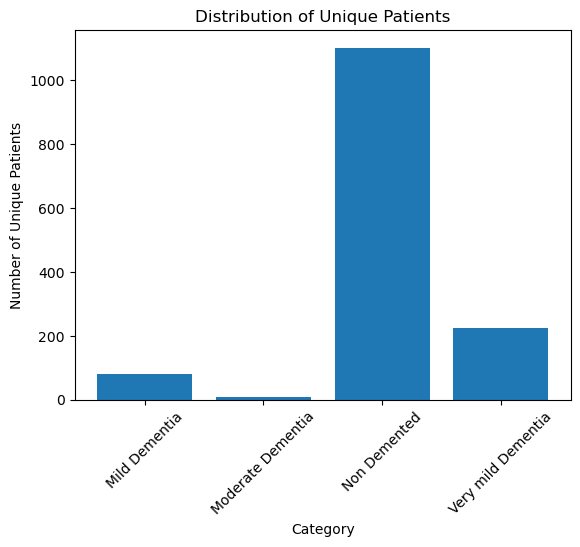

'\nOutput: \nMild Dementia: 82\nModerate Dementia: 8\nNon Demented: 1102\nVery mild Dementia: 225\n'

In [13]:
# Define the path to your dataset
dataset_path = './Data'

# List the categories
categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

# Initialize a dictionary to hold the count of unique patients in each category
patient_counts = {}

for category in categories:
    category_path = os.path.join(dataset_path, category)

    # Get all file names in the category
    file_names = os.listdir(category_path)

    # Extract unique patient identifiers from the file names
    # Split at the last underscore to separate the patient identifier from the slice number
    unique_patients = set('_'.join(name.split('_')[:-1]) for name in file_names)

    # Count the unique patients
    patient_counts[category] = len(unique_patients)

# Print the count of unique patients in each category
for category, count in patient_counts.items():
    print(f"{category}: {count}")

# Plotting the distribution
plt.bar(patient_counts.keys(), patient_counts.values())
plt.title('Distribution of Unique Patients')
plt.xlabel('Category')
plt.ylabel('Number of Unique Patients')
plt.xticks(rotation=45)
plt.show()

'''
Output: 
Mild Dementia: 82
Moderate Dementia: 8
Non Demented: 1102
Very mild Dementia: 225
'''

# Dataset Class Definition for Non-Series Dataset

In this section, we define a custom dataset class `AlzheimerDataset` for handling the Alzheimer's MRI images dataset. Each image in this dataset is treated as an individual sample. This class is crucial for loading the images and their corresponding labels efficiently during the training and evaluation of our deep learning models. It allows us to apply transformations to the dataset images and prepare them for input into the neural network.

In [14]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image categories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        for category in categories:
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                self.image_paths.append(os.path.join(category_path, img_name))
                self.labels.append(label_mapping[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, label_tensor

# Dataset Class Definition for Non-Series Dataset

In this section, we define a custom dataset class `AlzheimerDataset` for handling the Alzheimer's MRI images dataset. Each image in this dataset is treated as an individual sample. This class is crucial for loading the images and their corresponding labels efficiently during the training and evaluation of our deep learning models. It allows us to apply transformations to the dataset images and prepare them for input into the neural network.

### Data Augmentation and DataLoader Preparation

In this section, we initialize the dataset and then apply data augmentation techniques to increase the diversity of our dataset, which can lead to better model generalization. After initializing the Alzheimer's dataset class, we split the dataset into training, validation, and test sets. To address the issue of class imbalance, we calculate class weights and utilize these weights to create a weighted sampler for the training data. Finally, we prepare DataLoader objects for each subset of the dataset to facilitate efficient data loading during the model training and evaluation phases.

To effectively handle class imbalance, we employ a weight rebalancing strategy that ensures less frequent classes are given more importance during training. This is accomplished through the following steps:

1. **Calculate Class Sample Counts**: We compute the number of samples for each class in the dataset. This count helps in identifying the extent of imbalance and determining the appropriate weight that each class should receive.

2. **Compute Class Weights**: For each class, the weight is calculated as the inverse of its sample count. This method assigns higher weights to less frequent classes, thus amplifying their presence during the training process.

3. **Assign Sample Weights**: Each sample in the dataset is then assigned a weight corresponding to its class weight. This results in a weighted distribution where the significance of each sample is adjusted according to its weight.

4. **Weighted Random Sampler**: In the training DataLoader, a WeightedRandomSampler is used with these sample weights. This sampler ensures that data batches are selected in a manner that reflects the assigned weights, providing more representation to underrepresented classes and mitigating the effects of class imbalance.

By applying these steps, we ensure that the training process accounts for all classes equitably, preventing the model from biasing towards the majority classes and thereby achieving a more balanced and accurate prediction across all classes.


In [15]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the image categories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        for category in categories:
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                self.image_paths.append(os.path.join(category_path, img_name))
                self.labels.append(label_mapping[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize the full dataset without transforms
full_dataset = AlzheimerDataset(root_dir='Data')

# Stratify split the dataset
np_labels = np.array(full_dataset.labels)
train_idx, val_test_idx = train_test_split(np.arange(len(np_labels)), test_size=0.3, stratify=np_labels, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, stratify=np_labels[val_test_idx], random_state=42)

# Create and transform subsets
train_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=train_transforms), train_idx)
val_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=val_test_transforms), val_idx)
test_dataset = Subset(AlzheimerDataset(root_dir='Data', transform=val_test_transforms), test_idx)

# Calculate and apply class weights
class_weights = [1.0 / np.sum(np_labels == i) for i in range(4)]
weights = torch.DoubleTensor([class_weights[label] for label in np_labels[train_idx]])
train_sampler = WeightedRandomSampler(weights, len(weights))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Dataset Class Definition for Series Dataset

This section defines the `AlzheimerSeriesDataset` class for handling a series dataset where each sample consists of 61 slices from a single patient's MRI scan. Although we did not end up using this class in our project, it's designed to manage datasets where the entirety of a patient's scan, represented as a series of images, forms a single data point. This approach could be useful for models that take into account the full depth of scans or for sequence-based models like RNNs or 3D CNNs.

### Data Preparation for Series Dataset

This section outlines the process of preparing the series dataset for training, validation, and testing. We define data augmentation techniques to enhance the diversity of our dataset, which can improve the model's ability to generalize. Then, we instantiate the series dataset, calculate sample weights to address class imbalance, and split the dataset into training, validation, and test sets. Finally, we set up DataLoader objects for each set, ensuring that the training data are sampled in a balanced manner to mitigate the effects of class imbalance.

In [16]:
class AlzheimerSeriesDataset(Dataset):
    """
    A custom Dataset class for handling series of MRI images, where each series represents a single patient's scan.

    Attributes:
        root_dir (str): Directory containing image categories.
        transform (callable, optional): Transform to be applied to each image in a series.
        series_paths (list): List of paths for each image in the series.
        labels (list): List of labels corresponding to each series.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object, storing paths for series of images and their labels.
        
        Args:
            root_dir (str): Directory containing image categories.
            transform (callable, optional): Transform to apply to each image in the series.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.series_paths = []
        self.labels = []

        categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
        label_mapping = {category: idx for idx, category in enumerate(categories)}

        # Organize images into series based on patient ID
        for category in categories:
            category_path = os.path.join(root_dir, category)
            patient_series = {}  # Dictionary to hold image paths for each patient

            # Aggregate images into series based on patient ID
            for img_name in os.listdir(category_path):
                patient_id = '_'.join(img_name.split('_')[:-1])
                img_path = os.path.join(category_path, img_name)

                if patient_id not in patient_series:
                    patient_series[patient_id] = []
                patient_series[patient_id].append(img_path)

            # Store only complete series with the correct number of images
            for patient_id, img_paths in patient_series.items():
                if len(img_paths) == 61:  # Assuming each series should have 61 images
                    self.series_paths.append(sorted(img_paths))  # Ensure images are in order
                    self.labels.append(label_mapping[category])

    def __len__(self):
        """
        Returns the total number of series in the dataset.
        """
        return len(self.series_paths)

    def __getitem__(self, idx):
        """
        Retrieves a series of images and its label at the specified index.
        
        Args:
            idx (int): Index of the data series to retrieve.
            
        Returns:
            series_stack (torch.Tensor): The stack of images corresponding to the series.
            label (int): The label of the series.
        """
        series_paths = self.series_paths[idx]
        series_images = [Image.open(img_path).convert('L') for img_path in series_paths]  # Convert images to grayscale

        # Apply transformation to each image in the series if a transform is specified
        if self.transform:
            series_images = [self.transform(image) for image in series_images]

        # Stack images to form a tensor representing the series
        series_stack = torch.stack(series_images, dim=0)
        label = self.labels[idx]

        return series_stack, label

# Initialize the dataset without any transformations
dataset = AlzheimerSeriesDataset(root_dir='./Data')

# Split the dataset into train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define transformations for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformations to the training dataset
train_dataset = Subset(dataset, train_dataset.indices)
train_dataset.dataset.transform = train_transform

# Calculate class weights for balancing
class_sample_count = np.array([len(np.where(np.array(dataset.labels) == t)[0]) for t in np.unique(dataset.labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in dataset.labels])
train_weights = np.array([samples_weight[idx] for idx in train_dataset.indices])

# Create the sampler for the training set
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))

# Number of workers for data loading
num_workers = 2

# Create the DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Defining a Common Training Function for All Models

In this section, we define a universal training function that can be applied to all models since they share common inputs and outputs. This function will handle the model training and validation processes, including features like saving model checkpoints, tracking training and validation metrics, and handling interruptions gracefully to save the current training state. The use of a common training function streamlines the training process across different models, ensuring consistency and reducing code redundancy. This approach not only facilitates the management of different neural network training processes but also ensures that model evaluation is standardized and comparable across different model architectures.


In [ ]:
def save_performance_metrics(performance_data, model_dir, filename):
    """
    Saves performance metrics to a JSON file.
    """
    filepath = os.path.join(model_dir, filename)
    with open(filepath, 'w') as file:
        json.dump(performance_data, file)
    print(f"Metrics saved to {filepath}")

def save_model_checkpoint(model, model_dir, filename):
    """
    Saves the model checkpoint to a file.
    """
    filepath = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def handle_keyboard_interrupt(model, model_dir, performance_data, last_epoch, epoch,adv=False):
    """
    Handles keyboard interrupt by saving the current model state and performance metrics.
    """
    model_filename = 'interrupted.pth' if not adv else 'adv_interrupted.pth'
    performance_filename = f'interrupted_performance_{last_epoch+1}_{epoch+1}.json'
    save_model_checkpoint(model, model_dir, model_filename)
    save_performance_metrics(performance_data, model_dir, performance_filename)

# Implementing Adversarial Training with FGSM Attack

In this section, we detail the implementation of a generic adversarial training function, which is designed to enhance the robustness of neural network models against adversarial attacks, specifically through the Fast Gradient Sign Method (FGSM). Adversarial training is a defense mechanism that incorporates adversarially perturbed examples into the training process, aiming to prepare the model to resist potential adversarial exploits.

FGSM is a popular technique for generating adversarial examples, which are slightly modified versions of the original inputs, crafted to deceive the model into making incorrect predictions. These modifications are based on the gradient of the loss with respect to the input data, ensuring the perturbations are in the direction that maximizes the loss, thereby leading the model to misclassify the perturbed image.

During training, the model is exposed to both clean (original) and adversarial examples. This exposure enables the model to learn and adapt to these perturbations, improving its ability to generalize and maintain accuracy even when faced with manipulated inputs.

The adversarial training process iteratively adjusts the model parameters not only to minimize the loss on clean data but also to withstand the adversarial examples. The gradual introduction of adversarial examples, with an increasing level of perturbation (epsilon), allows the model to progressively learn to counter these attacks without compromising its performance on clean data.

By incorporating adversarial training into the model's learning routine, we aim to develop a neural network that is not only accurate in its predictions but also resilient against the manipulative tactics employed in adversarial attacks. This dual focus ensures the trained model is robust and reliable, characteristics essential for practical deployment, especially in critical applications like medical imaging analysis.


In [ ]:
def save_performance_metrics(performance_data, model_dir, filename):
    """
    Saves performance metrics to a JSON file.
    """
    filepath = os.path.join(model_dir, filename)
    with open(filepath, 'w') as file:
        json.dump(performance_data, file)
    print(f"Metrics saved to {filepath}")

def save_model_checkpoint(model, model_dir, filename):
    """
    Saves the model checkpoint to a file.
    """
    filepath = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def handle_keyboard_interrupt(model, model_dir, performance_data, last_epoch, epoch,adv=False):
    """
    Handles keyboard interrupt by saving the current model state and performance metrics.
    """
    model_filename = 'interrupted.pth' if not adv else 'adv_interrupted.pth'
    performance_filename = f'interrupted_performance_{last_epoch+1}_{epoch+1}.json'
    save_model_checkpoint(model, model_dir, model_filename)
    save_performance_metrics(performance_data, model_dir, performance_filename)


def train_model(model, train_loader, val_loader, device, model_checkpoint_path, model_name, epochs=5, load_pretrained=False, last_epoch=-1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_f1score = 0
    best_val_loss = float('inf')

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    val_f1score_history = []

    # Setup metrics
    val_f1_score = torchmetrics.F1Score(num_classes=4, average='macro', task='multiclass').to(device)
    val_accuracy = torchmetrics.Accuracy(num_classes=4, task='multiclass').to(device)


    model_save_dir = os.path.join(model_checkpoint_path, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    if load_pretrained and last_epoch >= 0:
        checkpoint_path = os.path.join(model_save_dir, f'epoch_{last_epoch}.pth')
        if os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"Loaded checkpoint from {checkpoint_path}")

    try:
        for epoch in range(last_epoch + 1, last_epoch + 1 + epochs):
            model.train()
            total_train_loss = 0

            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            val_f1_score.reset()
            val_accuracy.reset()

            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device)
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    total_val_loss += loss.item()

                    predictions = outputs.argmax(dim=1)
                    val_f1_score.update(predictions, targets)
                    val_accuracy.update(predictions, targets)

            avg_val_loss = total_val_loss / len(val_loader)
            current_val_f1score = val_f1_score.compute().item()
            current_val_accuracy = val_accuracy.compute().item()
            val_loss_history.append(avg_val_loss)
            val_accuracy_history.append(current_val_accuracy)
            val_f1score_history.append(current_val_f1score)

            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1 Score: {current_val_f1score:.4f}, Val Accuracy: {current_val_accuracy:.4f}")

            # Save model if improved
            if current_val_f1score > best_val_f1score or avg_val_loss < best_val_loss:
                save_model_checkpoint(model, model_save_dir, f'epoch_{epoch}.pth')
                best_val_f1score = current_val_f1score
                best_val_loss = avg_val_loss

        # Save metrics at the end of training
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        save_performance_metrics(performance_data, model_save_dir, 'final_performance_metrics.json')

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        performance_data = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'val_f1score': val_f1score_history,
            'val_accuracy': val_accuracy_history
        }
        handle_keyboard_interrupt(model, model_save_dir, performance_data, last_epoch, epoch)
        print("All state saved after interruption.")